## BQ Day 4?
____

Today, we're going to be working with a Bitcoin dataset (Bitcoin is a popular but volatile cryptocurrency). We're going to use a common table expression (CTE) to find out how many Bitcoin transactions were made per month for the entire timespan of this dataset.

We need to get our environment set up:

In [1]:
import numpy as np
import pandas as pd

# import package with helper functions 
import bq_helper

# create a helper object for this dataset
bitcoin_blockchain = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                              dataset_name="bitcoin_blockchain")

In [2]:
bitcoin_blockchain.list_tables()

['blocks', 'transactions']

In [3]:
bitcoin_blockchain.table_schema('transactions')

[SchemaField('timestamp', 'integer', 'NULLABLE', None, ()),
 SchemaField('transaction_id', 'string', 'NULLABLE', None, ()),
 SchemaField('inputs', 'record', 'REPEATED', None, (SchemaField('input_script_bytes', 'bytes', 'NULLABLE', None, ()), SchemaField('input_script_string', 'string', 'NULLABLE', None, ()), SchemaField('input_script_string_error', 'string', 'NULLABLE', None, ()), SchemaField('input_sequence_number', 'integer', 'NULLABLE', None, ()), SchemaField('input_pubkey_base58', 'string', 'NULLABLE', None, ()), SchemaField('input_pubkey_base58_error', 'string', 'NULLABLE', None, ()))),
 SchemaField('outputs', 'record', 'REPEATED', None, (SchemaField('output_satoshis', 'integer', 'NULLABLE', None, ()), SchemaField('output_script_bytes', 'bytes', 'NULLABLE', None, ()), SchemaField('output_script_string', 'string', 'NULLABLE', None, ()), SchemaField('output_script_string_error', 'string', 'NULLABLE', None, ()), SchemaField('output_pubkey_base58', 'string', 'NULLABLE', None, ()), Sch

Now we're going to write a query to get the number of transactions per month. One problem here is that this dataset uses timestamps rather than dates, and they're stored in this dataset as integers. We'll have to convert these into a format that BigQuery recognizes using TIMESTAMP_MILLIS(). We can do that using a CTE and then write a second part of the query against the new, temporary table we created. This has the advantage of breaking up our query into two, logical parts. 

* Convert the integer to a timestamp
* Get information on the date of transactions from the timestamp

You can see the query I used to do this below.

In [4]:
query = """ WITH time AS 
            (
                SELECT TIMESTAMP_MILLIS(timestamp) AS trans_time,
                    transaction_id
                FROM `bigquery-public-data.bitcoin_blockchain.transactions`
            )
            SELECT COUNT(transaction_id) AS transactions,
                EXTRACT(MONTH FROM trans_time) AS month,
                EXTRACT(YEAR FROM trans_time) AS year
            FROM time
            GROUP BY year, month 
            ORDER BY year, month
        """

# note that max_gb_scanned is set to 21, rather than 1
transactions_per_month = bitcoin_blockchain.query_to_pandas_safe(query, max_gb_scanned=24)

Since they're returned sorted, we can just plot the raw results to show us the number of Bitcoin transactions per month over the whole timespan of this dataset.

Text(0.5,1,'Monthly Bitcoin Transcations')

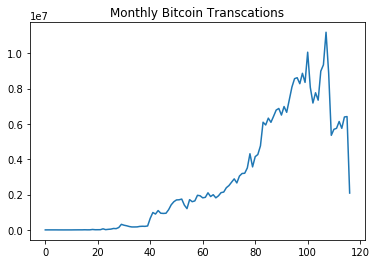

In [5]:
# import plotting library
import matplotlib.pyplot as plt

# plot monthly bitcoin transactions
plt.plot(transactions_per_month.transactions)
plt.title("Monthly Bitcoin Transcations")

Pretty cool, huh? :)

As you can see, common table expressions let you shift a lot of your data cleaning into SQL. That's an especially good thing in the case of BigQuery because it lets you take advantage of BigQuery's parallelization, which means you'll get your results more quickly.

# Scavenger hunt
___

> **Important note**: Today's dataset is bigger than the ones we've used previously, so your queries will be more than 1 Gigabyte. You can still run them by setting the "max_gb_scanned" argument in the `query_to_pandas_safe()` function to be large enough to run your query, or by using the `query_to_pandas()` function instead.

Now it's your turn! Here are the questions I would like you to get the data to answer. Practice using at least one alias in each query. 

* How many Bitcoin transactions were made each day in 2017?
    * You can use the "timestamp" column from the "transactions" table to answer this question. You can check the [notebook from Day 3](https://www.kaggle.com/rtatman/sql-scavenger-hunt-day-3/) for more information on timestamps.
* How many transactions are associated with each merkle root?
    * You can use the "merkle_root" and "transaction_id" columns in the "transactions" table to answer this question. 
    * Note that the earlier version of this question asked "How many *blocks* are associated with each merkle root?", which would be one block for each root. Apologies for the confusion!

In order to answer these questions, you can fork this notebook by hitting the blue "Fork Notebook" at the very top of this page (you may have to scroll up). "Forking" something is making a copy of it that you can edit on your own without changing the original.

In [6]:
# How many Bitcoin transactions were made each day in 2017?

query = """ with trans_day as 
(
select transaction_id, TIMESTAMP_MILLIS(timestamp) as trans_time
from `bigquery-public-data.bitcoin_blockchain.transactions`
)

select extract(year from trans_time) as year, 
extract(month from trans_time) as month,
extract(day from trans_time) as day, 
count(transaction_id) as counts

from trans_day
group by day, year, month
having year = 2017
order by day, month"""

transactions_per_day = bitcoin_blockchain.query_to_pandas_safe(query, max_gb_scanned=24)
transactions_per_day

,year,month,day,counts
0,2017,1,1,180502
1,2017,2,1,350560
2,2017,3,1,315883
3,2017,4,1,255871
4,2017,5,1,294786
5,2017,6,1,319709
6,2017,7,1,221856
7,2017,8,1,131875
8,2017,9,1,283670
9,2017,10,1,203653


Text(0.5,1,'Daily Bitcoin Transcations')

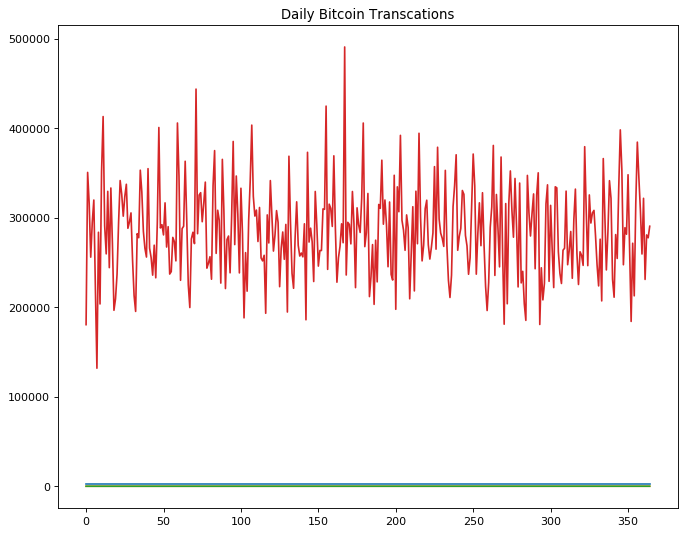

In [7]:
# import plotting library
import matplotlib.pyplot as plt

# plot monthly bitcoin transactions
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(transactions_per_day)
plt.title("Daily Bitcoin Transcations")

In [8]:
# How many transactions are associated with each merkle root?

query = """ 
select count(transaction_id) as counts, merkle_root
from `bigquery-public-data.bitcoin_blockchain.transactions`
group by merkle_root
order by counts desc"""

merkel_trans = bitcoin_blockchain.query_to_pandas_safe(query,max_gb_scanned = 42)
merkel_trans

,counts,merkle_root
0,12239,dc1bde29f6912ba825138118676988a0e7f839054155db...
1,9647,03ef22104e4561d1c8198015157aa80ec08f1aaef676bf...
2,6451,52461d6e9d181204112ee8ca440921d5df88763ddb6e86...
3,6144,60f1b83982cd4588a8a99b66bb24c5e6d7bb15d34c6a90...
4,6084,73733e699f12f312843b99b309d65ac499c57507d2120f...
5,5973,c59fd39bd08b42ff1d6c175439af2dc74942bb708e517b...
6,5946,e3d2085f137f83e14e572784ad353ed9bcc02a65e3946a...
7,5944,012c4d5cb8c1fb95325d46f6c47634300b89ef4f99fe56...
8,5937,37a3c1b5d1da8450c0b7c2ed1768cc9d8ccd8c5e59fb59...
9,5866,e395b6a84f591ef69be39110e20ffc7c573e5186cf7f09...


Text(0.5,1,'Transactions associated with each Merkle root')

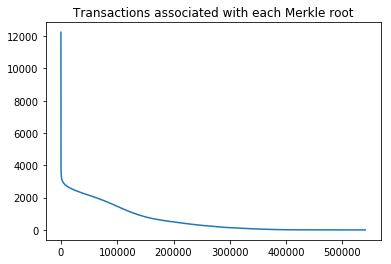

In [9]:
plt.plot(merkel_trans.counts)
plt.title('Transactions associated with each Merkle root')

Please feel free to ask any questions you have in this notebook or in the [Q&A forums](https://www.kaggle.com/questions-and-answers)! 

Also, if you want to share or get comments on your kernel, remember you need to make it public first! You can change the visibility of your kernel under the "Settings" tab, on the right half of your screen.